In [1]:
import sys
import os
import torch

os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='2'

import numpy as np
import plotly.graph_objects as go
import torch.nn.functional as F

import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

In [2]:
def toDisplay(x, target_dim = None):
    while(target_dim is not None and x.dim() > target_dim):
        x = x[0]
    return x.detach().cpu().numpy()

In [3]:
from pytorch3d.transforms import Transform3d,Rotate, rotation_6d_to_matrix, se3_exp_map
from equivariant_pose_graph.utils.se3 import *
from equivariant_pose_graph.utils.display import *
from equivariant_pose_graph.dataset.point_cloud_dataset import PointCloudDataset

In [5]:
from equivariant_pose_graph.models.transformer_flow import ResidualFlow_DiffEmbTransformer
from equivariant_pose_graph.training.flow_equivariance_training_module_nocentering_eval_init import EquivarianceTestingModule
place_checkpoint_file='/media/jwang/chuerp-archive/backup_chuer/chuerp_home/good_mug_models/rm/epoch=120-step=15125.ckpt'
place_network = ResidualFlow_DiffEmbTransformer(
                    emb_nn='dgcnn', return_flow_component=True, center_feature=True,
                    inital_sampling_ratio=1)
place_model = EquivarianceTestingModule(
    place_network,
    lr=1e-4,
    image_log_period=100,
    weight_normalize='l1',
    loop=1
)

place_model.cuda()
place_model.load_state_dict(torch.load(place_checkpoint_file)['state_dict']);

In [9]:
# from torch.utils.data import DataLoader

# dataset = PointCloudDataset('/home/bokorn/src/ndf_robot/data/renders', 
#                             cloud_type='init',
#                             dataset_indices=[3])
# dataloader = DataLoader(dataset)
from equivariant_pose_graph.dataset.point_cloud_data_module import MultiviewDataModule
mug0_dm = MultiviewDataModule(
        dataset_root='/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders',
        test_dataset_root='/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders',
        dataset_index=[0],
#         dataset_index="None",
        action_class=0,
        anchor_class=1,
        dataset_size=1000,
        rotation_variance=np.pi/180 * 180,
        translation_variance=0.5,
        batch_size=1,
        num_workers=1,
        cloud_type="teleport",
        num_points=1024,
        overfit=True,
        num_overfit_transforms=1,
        seed_overfit_transforms=True,
        set_Y_transform_to_identity=True,
        synthetic_occlusion=False,
        ball_radius=0.1
)
mug0_dm.setup()

dataloader = mug0_dm.train_dataloader()


TRAIN Dataset
/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/0_teleport_obj_points.npz

Overfitting transform lists in PointCloudDataset:
	-TO: [tensor([[[ 0.4226,  0.7497, -0.5093,  0.0000],
         [-0.8577,  0.1492, -0.4920,  0.0000],
         [-0.2929,  0.6448,  0.7060,  0.0000],
         [ 0.0535,  0.0609,  0.0234,  1.0000]]])]
	-T1: [tensor([[[ 5.4887e-01, -1.2942e-01,  8.2583e-01,  0.0000e+00],
         [-4.9779e-01,  7.4305e-01,  4.4729e-01,  0.0000e+00],
         [-6.7152e-01, -6.5660e-01,  3.4342e-01,  0.0000e+00],
         [ 1.2892e-02,  1.2668e-02, -5.3782e-04,  1.0000e+00]]])]
	-T2: [tensor([[[1., 0., 0., 0.],
         [0., 1., 0., 0.],
         [0., 0., 1., 0.],
         [0., 0., 0., 1.]]])]
VAL Dataset
/home/jwang/code/equivariant_pose_graph/data/train_data_duprack_bothmugrack/renders/0_teleport_obj_points.npz

Overfitting transform lists in PointCloudDataset:
	-TO: [tensor([[[ 0.4226,  0.7497, -0.5093,  0.0000],
         [-0.8577,  

In [10]:
from pytorch3d.transforms import Transform3d
from pytorch_lightning.utilities.seed import seed_everything

seed_everything(0)

for data in dataloader:
    points_action = data['points_action'].cuda()[:,:-2]
    points_anchor = data['points_anchor'].cuda()
    T0 = Transform3d(matrix=data['T0']).cuda()
    T1 = Transform3d(matrix=data['T1']).cuda()
    break

Global seed set to 0


In [11]:
res = place_model.get_transform(points_action, points_anchor)

pred_T_action = res['pred_T_action']
flow_action = res['flow_components']['flow_action'][:,:,:3]
pred_w_action = torch.sigmoid(res['flow_components']['flow_action'][:,:,3])
flow_anchor = res['flow_components']['flow_anchor'][:,:,:3]
pred_w_anchor = torch.sigmoid(res['flow_components']['flow_anchor'][:,:,3])
corr_flow_action = res['flow_components']['corr_flow_action']
corr_flow_anchor = res['flow_components']['corr_flow_anchor']
corr_points_action = res['flow_components']['corr_points_action']
corr_points_anchor = res['flow_components']['corr_points_anchor']
residual_flow_action = res['flow_components']['residual_flow_action']
residual_flow_anchor = res['flow_components']['residual_flow_anchor']
action_attn = res['flow_components']['action_attn']
anchor_attn = res['flow_components']['anchor_attn']

In [12]:
print(points_action.shape)
print(action_attn.shape)
print(corr_flow_action.shape)
print(points_anchor.shape)
print(anchor_attn.shape)
print(corr_flow_anchor.shape)

torch.Size([1, 1022, 3])
torch.Size([1, 1022, 1024])
torch.Size([1, 1022, 3])
torch.Size([1, 1024, 3])
torch.Size([1, 1024, 1022])
torch.Size([1, 1024, 3])


In [13]:
print((residual_flow_action.norm(dim=-1) * pred_w_action).mean())
print((residual_flow_anchor.norm(dim=-1) * pred_w_anchor).mean())

tensor(0.0054, device='cuda:0', grad_fn=<MeanBackward0>)
tensor(5.5914e-05, device='cuda:0', grad_fn=<MeanBackward0>)


In [14]:
post_action_pts = toDisplay(pred_T_action.transform_points(points_action))[0]
post_anchor_pts = toDisplay(pred_T_action.inverse().transform_points(points_anchor))[0]

action_pts = toDisplay(points_action)[0]
anchor_pts = toDisplay(points_anchor)[0]
action_flow = toDisplay(flow_action)[0]
action_flow_corr = toDisplay(corr_flow_action)[0]
action_flow_res = toDisplay(residual_flow_action)[0]
anchor_flow = toDisplay(flow_anchor)[0]
# vis_scores = toDisplay(scores)[0]
vis_attn_act = toDisplay(action_attn)[0]
vis_attn_anc = toDisplay(anchor_attn)[0]
action_w = toDisplay(pred_w_action)[0]
anchor_w = toDisplay(pred_w_anchor)[0]

In [15]:
from equivariant_pose_graph.utils.visualizations import visualize_correspondence

fig = visualize_correspondence(action_pts, anchor_pts, vis_attn_act, action_flow, 
                               weights = action_w, skip=50)
fig.add_trace(
    go.Scatter3d(
        x = post_action_pts[:,0], 
        y = post_action_pts[:,1], 
        z = post_action_pts[:,2], 
        mode = 'markers',
        hoverinfo = 'none',
    ), 
    row=1,col=1
)

scatter_post_action = fig.data[-1]
scatter_post_action.marker.size = 1
scatter_post_action.marker.opacity = 0.5
# scatter_post_action.marker.color = '#9467bd'
# remove_background(fig)



fig

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'marker': {'color': array([6.8600684e-02, 7.81…

In [16]:
from equivariant_pose_graph.utils.visualizations import visualize_correspondence

fig = visualize_correspondence(anchor_pts, action_pts, vis_attn_anc, anchor_flow, weights=anchor_w, skip=50)
fig.add_trace(
    go.Scatter3d(
        x = post_anchor_pts[:,0], 
        y = post_anchor_pts[:,1], 
        z = post_anchor_pts[:,2], 
        mode = 'markers',
        hoverinfo = 'none',
    ), 
    row=1,col=1
)

scatter_post_anchor = fig.data[-1]
scatter_post_anchor.marker.size = 1
scatter_post_anchor.marker.opacity = 0.5

fig

FigureWidget({
    'data': [{'hoverinfo': 'none',
              'marker': {'color': array([3.0897755e-07, 8.77…

In [13]:
Hacky Jupyter Notebook Break 

SyntaxError: invalid syntax (<ipython-input-13-761bd19ebfbf>, line 1)

<IPython.core.display.Javascript object>


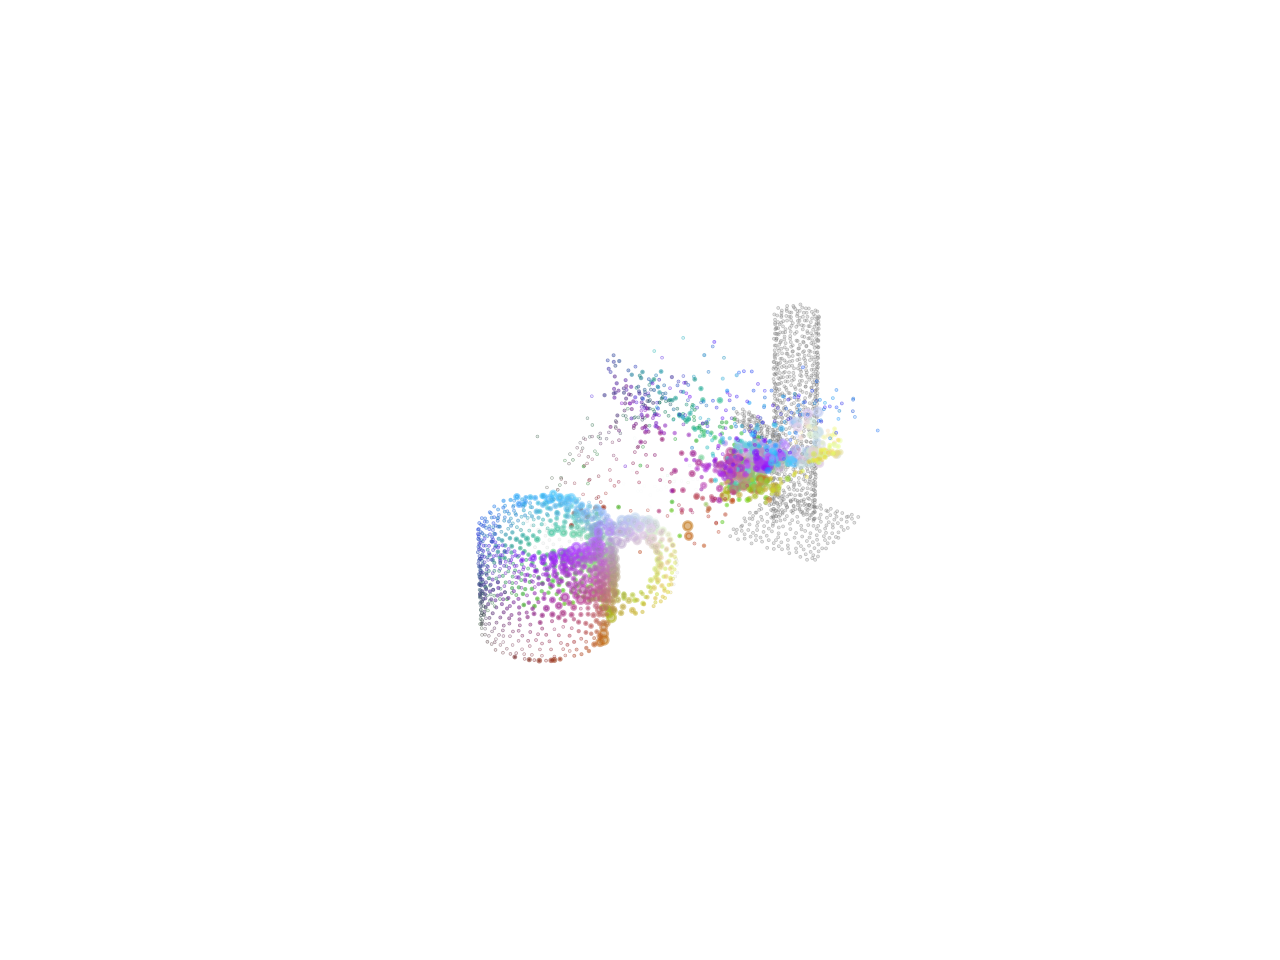

(-0.1835369847714901,
 0.2923473797738552,
 -0.09196615293622018,
 0.38391821160912515)

In [14]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
fig = plt.figure()

skip = 1
flow_skip = 100

ax = fig.add_subplot(111, projection='3d')
c_action = (action_pts - np.min(action_pts, axis=0))/(np.max(action_pts, axis=0) - np.min(action_pts, axis=0))


action_corr = action_pts + action_flow
ax.scatter3D(
    action_pts[::skip,0], 
    action_pts[::skip,1], 
    action_pts[::skip,2],
    s=10*action_w, c=c_action, alpha=0.5)

ax.scatter3D(
    action_pts[::skip,0], 
    action_pts[::skip,1], 
    action_pts[::skip,2],
    s=0.1, c='gray', alpha=0.1)

ax.scatter3D(
    anchor_pts[::skip,0], 
    anchor_pts[::skip,1], 
    anchor_pts[::skip,2],
    s=0.1, c='gray', alpha=0.5)

ax.scatter3D(
    action_corr[::skip,0], 
    action_corr[::skip,1], 
    action_corr[::skip,2],
    s=10*action_w, c=c_action, alpha=0.5)

set_axes_equal(ax)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# ax.xaxis.pane.set_edgecolor('w')
# ax.yaxis.pane.set_edgecolor('w')
# ax.zaxis.pane.set_edgecolor('w')

ax.grid(False)
ax.axis('off')

In [21]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
fig = plt.figure()

skip = 1
flow_skip = 100

ax = fig.add_subplot(111, projection='3d')
c_anchor = (anchor_pts - np.min(anchor_pts, axis=0))/(np.max(anchor_pts, axis=0) - np.min(anchor_pts, axis=0))


anchor_corr = anchor_pts + anchor_flow
ax.scatter3D(
    action_pts[::skip,0], 
    action_pts[::skip,1], 
    action_pts[::skip,2],
    s=10*action_w, c='gray', alpha=0.5)

ax.scatter3D(
    anchor_pts[::skip,0], 
    anchor_pts[::skip,1], 
    anchor_pts[::skip,2],
    s=10*anchor_w, c=c_anchor, alpha=0.5)

ax.scatter3D(
    anchor_pts[::skip,0], 
    anchor_pts[::skip,1], 
    anchor_pts[::skip,2],
    s=0.1, c='gray', alpha=0.1)

# ax.scatter3D(
#     anchor_corr[::skip,0], 
#     anchor_corr[::skip,1], 
#     anchor_corr[::skip,2],
#     s=10*anchor_w, c=c_anchor, alpha=0.5)

set_axes_equal(ax)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

# ax.xaxis.pane.set_edgecolor('w')
# ax.yaxis.pane.set_edgecolor('w')
# ax.zaxis.pane.set_edgecolor('w')

ax.grid(False)
ax.axis('off')

<IPython.core.display.Javascript object>

(-0.18865511268377305,
 0.2872292518615723,
 -0.09196615293622018,
 0.38391821160912515)